In [2]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D
from keras import regularizers
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np



In [3]:
train1 = pd.read_csv('train_1.csv', sep=',', header=0)
train2 = pd.read_csv('train_2.csv', sep=',', header=0)
train3 = pd.read_csv('train_3.csv', sep=',', header=0)
train4 = pd.read_csv('train_4.csv', sep=',', header=0)


In [4]:
def getData(store_num):
    train = pd.concat([train1, train2, train3, train4], ignore_index=True)
    train = train[train['store_nbr'] == store_num]
    train = train.drop(columns=["id", "store_nbr"], axis=1)
    train_data = train.pivot_table(index=['date'], columns="family", values='sales')
    train_data["total_sales"] = train_data[list(train_data.columns[1:])].sum(axis=1)
    data = train_data
    return data

In [5]:
def dataSplit(data, start, middle):
    train = data.iloc[:start, -1].values
    evalu = data.iloc[start:middle, -1].values
    test = data.iloc[middle:, -1].values
    return train, evalu, test

In [6]:
sc = MinMaxScaler(feature_range=(0,1))

def transform_data(data, sequence_length):
    data = np.array(data)
    data = data.reshape(-1,1)
    data_scaled = sc.fit_transform(data)

    data_x = []
    data_y = []

    for i in range(sequence_length, len(data) ):
        data_x.append(data_scaled[i-sequence_length:i, 0])
        data_y.append(data_scaled[i,0])

    data_x, data_y = np.array(data_x), np.array(data_y)
    data_x = np.reshape(data_x, (data_x.shape[0], data_x.shape[1], 1))

    return data_x, data_y

In [7]:
def createModel(sequence_length, num_units, activation_func, reg_strength, learning_rate):
    model = Sequential()
    
    model.add(LSTM(units=num_units, return_sequences= True, input_shape=(sequence_length, 1),
            kernel_regularizer=regularizers.l2(reg_strength),
            activation=activation_func))
    
    model.add(LSTM(units=num_units, return_sequences= True, input_shape=(sequence_length, 1),
            kernel_regularizer=regularizers.l2(reg_strength),
            activation=activation_func))
    model.add(LSTM(units=num_units, input_shape=(sequence_length, 1),
            kernel_regularizer=regularizers.l2(reg_strength),
            activation=activation_func))
    
    model.add(Dense(80))

    # Define optimizer and loss function
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='msle')
    
    return model


In [8]:
def trainModel(model, train_x, train_y, eval_x, eval_y, num_epochs, batch_size):
    data = model.fit(train_x, train_y, epochs=num_epochs, batch_size=batch_size, validation_data=(eval_x, eval_y))
    return data

In [9]:
def predict(model, test_data):
    pred = model.predict(test_data)
    pred = sc.inverse_transform(pred)
    return pred 

In [10]:
def plotPredict(test, pred,title):
    plt.plot(test, color='red', label='Real Values')
    plt.plot(pred, color='blue', label='Predicted Values')
    plt.title('Model vs. Store #' + str(title))
    plt.xlabel('Days after our last training day')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

In [11]:
def plotLoss(loss, store_num):
    plt.plot(loss.history['loss'], color = 'red', label = "Loss")
    plt.plot(loss.history['val_loss'], color = 'blue', label = "Loss Validation")
    plt.title("Store # " + str(store_num) + ": Loss vs Training Validation Loss " )
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [12]:
def trainAllStores(model, store_ammount, num_epochs, batch_size, start_bounds, middle_bounds, sequence_length):
    for i in range(1,store_ammount):
        # Get data for that store
        data = getData(i)
                
        # Split into train, test, evaluation
        train_data, eval_data, test_data = dataSplit(data, start_bounds, middle_bounds)
        
        # Transform data into proper size
        train_x, train_y = transform_data(train_data, sequence_length)
        eval_x, eval_y = transform_data(eval_data, sequence_length)
        test_x, test_y = transform_data(test_data, sequence_length)
                
        # Train model on current store
        loss = trainModel(model, train_x, train_y, eval_x, eval_y, num_epochs, batch_size)
        
        # Plot the loss functions
        plotLoss(loss, i)
        

In [13]:
def predictAllStores(model, num_stores, start_bounds, middle_bounds):
    for i in range(1, num_stores):
        # Get data for that store
        data = getData(i)
        
        # Split into train, test, evaluation
        train_data, eval_data, test_data = dataSplit(data, start_bounds, middle_bounds)
        
        # Transform data into proper size
        train_x, train_y = transform_data(train_data, sequence_length)
        eval_x, eval_y = transform_data(eval_data, sequence_length)
        test_x, test_y = transform_data(test_data, sequence_length)
        
        # Use model to predict current store
        pred = predict(model, test_x)
        pred = pred[:, 1]
        
        # Plot predictions vs actual
        plotPredict(test_data, abs(pred), i)
        

In [14]:
def predictOneStore(model, store_num, start_bounds, middle_bounds):
     # Get data for that store
    data = getData(store_num)
    # Split into train, test, evaluation
    train_data, eval_data, test_data = dataSplit(data, start_bounds, middle_bounds)
        
    # Transform data into proper size
    train_x, train_y = transform_data(train_data, sequence_length)
    eval_x, eval_y = transform_data(eval_data, sequence_length)
    test_x, test_y = transform_data(test_data, sequence_length)
        
    # Use model to predict current store
    pred = predict(model, test_x)
    pred = pred[:, 1]
        
    # Plot predictions vs actual
    plotPredict(test_data, abs(pred), store_num)

In [15]:
# Set bounds for train, eval, test
start_bounds = 1000
middle_bounds = 1300

# Sequence length of sequential data (days)
sequence_length = 7

# Initial conditions for model
num_units = 55
activation_func = 'relu'
reg_strength = 0.00
learning_rate = 0.0001

# Training conditions
batch_size = 42
num_epochs = 35
num_stores = 20

#Create model
model = createModel(sequence_length,num_units, activation_func, reg_strength, learning_rate)


Here I will train our model on store #1. After training on store #1, I will show how it predicts the results of store #41. After this, I will then train our model on an additional 20 stores then show how it predicts store #41, showing how much the model has learned as a result

Epoch 1/35


2023-04-17 21:05:48.448069: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


24/24 [==============================] - 2s 21ms/step - loss: 0.1444 - val_loss: 0.1552
Epoch 2/35
24/24 [==============================] - 0s 10ms/step - loss: 0.1424 - val_loss: 0.1527
Epoch 3/35
24/24 [==============================] - 0s 9ms/step - loss: 0.1395 - val_loss: 0.1489
Epoch 4/35
24/24 [==============================] - 0s 10ms/step - loss: 0.1352 - val_loss: 0.1431
Epoch 5/35
24/24 [==============================] - 0s 10ms/step - loss: 0.1283 - val_loss: 0.1334
Epoch 6/35
24/24 [==============================] - 0s 10ms/step - loss: 0.1168 - val_loss: 0.1173
Epoch 7/35
24/24 [==============================] - 0s 10ms/step - loss: 0.0979 - val_loss: 0.0922
Epoch 8/35
24/24 [==============================] - 0s 10ms/step - loss: 0.0738 - val_loss: 0.0700
Epoch 9/35
24/24 [==============================] - 0s 10ms/step - loss: 0.0637 - val_loss: 0.0672
Epoch 10/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0620 - val_loss: 0.0661
Epoch 11/35
24/24 [===

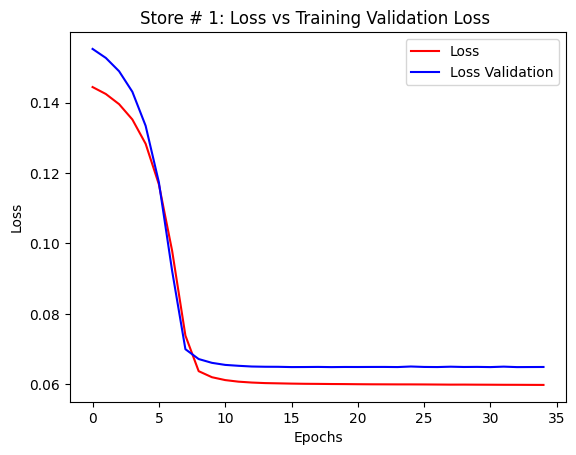

In [16]:
# Set up function to train just store #1
trainAllStores(model, 2, num_epochs, batch_size, start_bounds, middle_bounds, sequence_length)

12/12 [==============================] - 0s 2ms/step


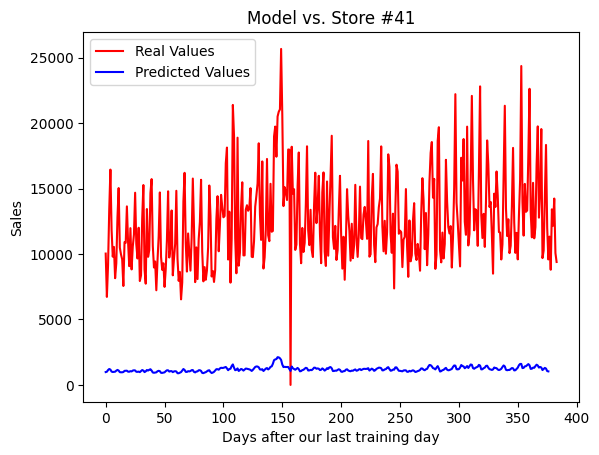

In [17]:
# Use model to predict store #41
store_num = 41
predictOneStore(model, store_num, start_bounds, middle_bounds)

Here I will train the model on 20 additional stores and predict store #41 again.

Epoch 1/35
24/24 [==============================] - 0s 10ms/step - loss: 0.0598 - val_loss: 0.0649
Epoch 2/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0598 - val_loss: 0.0648
Epoch 3/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0598 - val_loss: 0.0648
Epoch 4/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0597 - val_loss: 0.0649
Epoch 5/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0598 - val_loss: 0.0649
Epoch 6/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0598 - val_loss: 0.0648
Epoch 7/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0597 - val_loss: 0.0648
Epoch 8/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0597 - val_loss: 0.0648
Epoch 9/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0597 - val_loss: 0.0648
Epoch 10/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0597 - val_loss: 0.0647
Epoch 11/35
24/24 

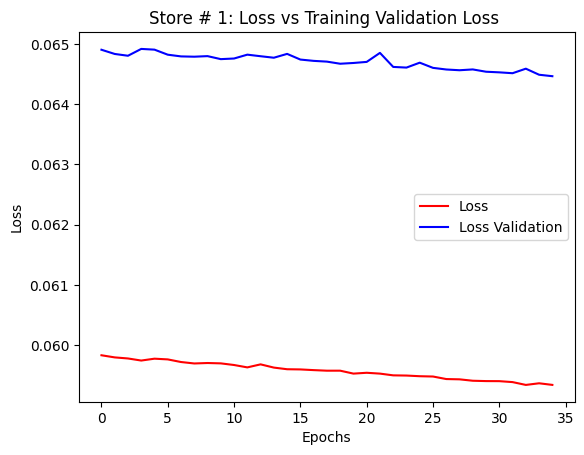

Epoch 1/35
24/24 [==============================] - 0s 10ms/step - loss: 0.0617 - val_loss: 0.0132
Epoch 2/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0617 - val_loss: 0.0138
Epoch 3/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0617 - val_loss: 0.0135
Epoch 4/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0616 - val_loss: 0.0140
Epoch 5/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0616 - val_loss: 0.0141
Epoch 6/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0616 - val_loss: 0.0145
Epoch 7/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0616 - val_loss: 0.0143
Epoch 8/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0616 - val_loss: 0.0149
Epoch 9/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0616 - val_loss: 0.0145
Epoch 10/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0616 - val_loss: 0.0144
Epoch 11/35
24/24 

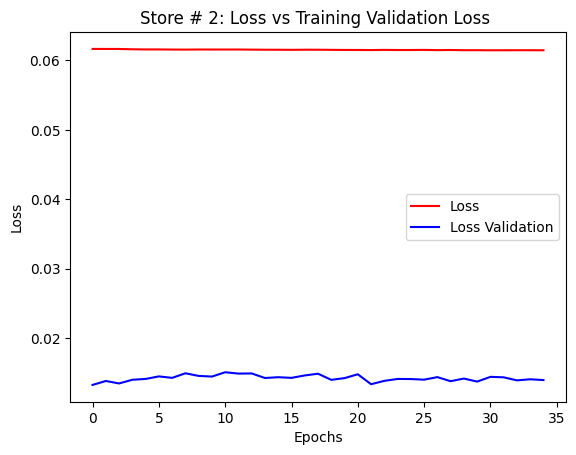

Epoch 1/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0553 - val_loss: 0.0756
Epoch 2/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0552 - val_loss: 0.0757
Epoch 3/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0553 - val_loss: 0.0757
Epoch 4/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0552 - val_loss: 0.0756
Epoch 5/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0552 - val_loss: 0.0756
Epoch 6/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0552 - val_loss: 0.0759
Epoch 7/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0553 - val_loss: 0.0756
Epoch 8/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0552 - val_loss: 0.0756
Epoch 9/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0552 - val_loss: 0.0755
Epoch 10/35
24/24 [==============================] - 0s 9ms/step - loss: 0.0552 - val_loss: 0.0755
Epoch 11/35
24/24 [

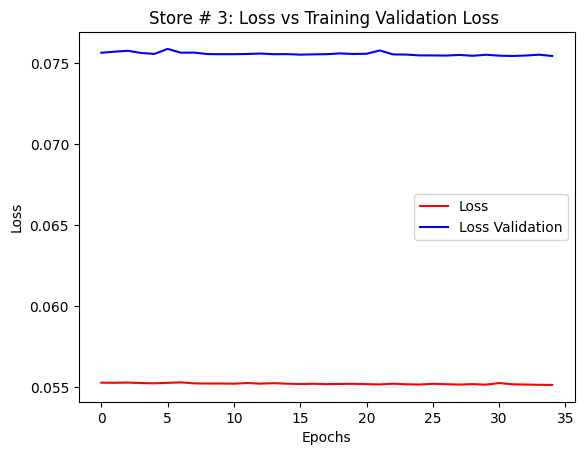

Epoch 1/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0464 - val_loss: 0.0702
Epoch 2/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0463 - val_loss: 0.0701
Epoch 3/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0463 - val_loss: 0.0706
Epoch 4/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0464 - val_loss: 0.0701
Epoch 5/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0464 - val_loss: 0.0701
Epoch 6/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0463 - val_loss: 0.0701
Epoch 7/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0463 - val_loss: 0.0701
Epoch 8/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0463 - val_loss: 0.0701
Epoch 9/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0463 - val_loss: 0.0702
Epoch 10/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0463 - val_loss: 0.0701
Epoch 11/35
24/24 [

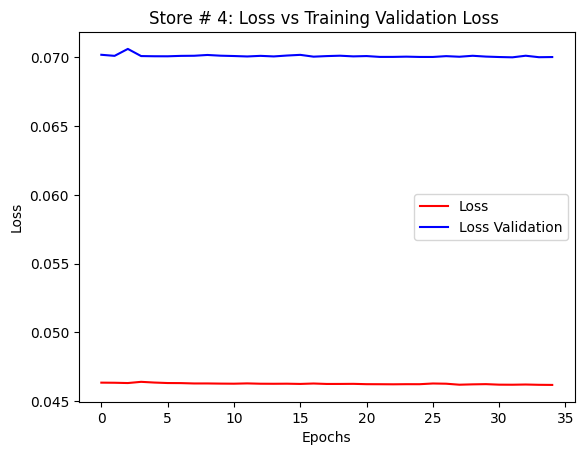

Epoch 1/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0437 - val_loss: 0.0693
Epoch 2/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0437 - val_loss: 0.0692
Epoch 3/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0438 - val_loss: 0.0692
Epoch 4/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0437 - val_loss: 0.0692
Epoch 5/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0437 - val_loss: 0.0691
Epoch 6/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0437 - val_loss: 0.0691
Epoch 7/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0437 - val_loss: 0.0692
Epoch 8/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0437 - val_loss: 0.0690
Epoch 9/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0437 - val_loss: 0.0690
Epoch 10/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0437 - val_loss: 0.0690
Epoch 11/35
24/24 [

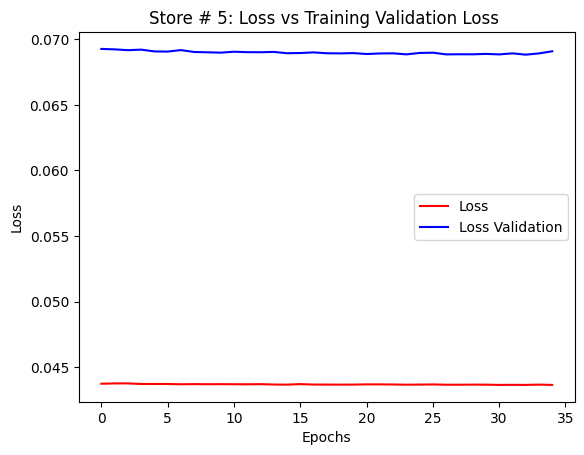

Epoch 1/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0507 - val_loss: 0.0640
Epoch 2/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0506 - val_loss: 0.0640
Epoch 3/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0506 - val_loss: 0.0640
Epoch 4/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0506 - val_loss: 0.0640
Epoch 5/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0507 - val_loss: 0.0640
Epoch 6/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0506 - val_loss: 0.0640
Epoch 7/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0506 - val_loss: 0.0640
Epoch 8/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0506 - val_loss: 0.0640
Epoch 9/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0506 - val_loss: 0.0641
Epoch 10/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0506 - val_loss: 0.0639
Epoch 11/35
24/24 [

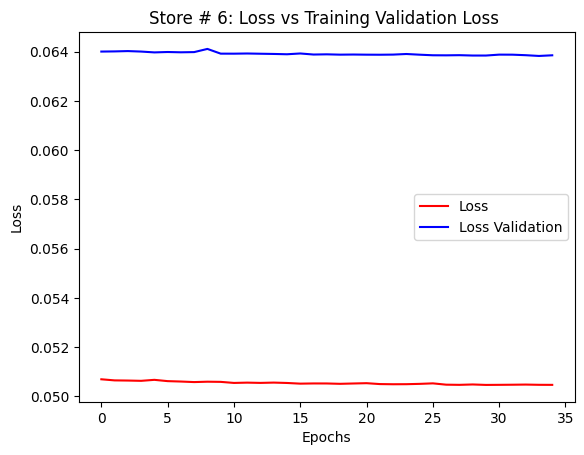

Epoch 1/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0576 - val_loss: 0.0772
Epoch 2/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0575 - val_loss: 0.0772
Epoch 3/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0575 - val_loss: 0.0771
Epoch 4/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0574 - val_loss: 0.0771
Epoch 5/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0574 - val_loss: 0.0771
Epoch 6/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0574 - val_loss: 0.0770
Epoch 7/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0574 - val_loss: 0.0770
Epoch 8/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0574 - val_loss: 0.0770
Epoch 9/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0574 - val_loss: 0.0773
Epoch 10/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0573 - val_loss: 0.0771
Epoch 11/35
24/24 [

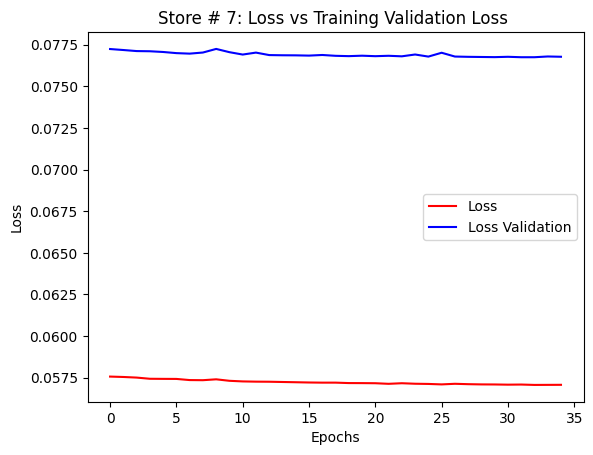

Epoch 1/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0595 - val_loss: 0.0769
Epoch 2/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0593 - val_loss: 0.0768
Epoch 3/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0593 - val_loss: 0.0768
Epoch 4/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0591 - val_loss: 0.0767
Epoch 5/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0591 - val_loss: 0.0767
Epoch 6/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0591 - val_loss: 0.0768
Epoch 7/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0591 - val_loss: 0.0766
Epoch 8/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0590 - val_loss: 0.0766
Epoch 9/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0590 - val_loss: 0.0766
Epoch 10/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0590 - val_loss: 0.0766
Epoch 11/35
24/24 [

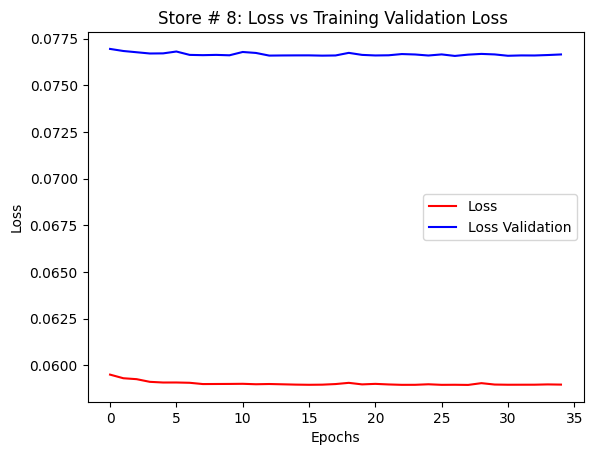

Epoch 1/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0347 - val_loss: 0.0583
Epoch 2/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0347 - val_loss: 0.0584
Epoch 3/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0347 - val_loss: 0.0585
Epoch 4/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0347 - val_loss: 0.0586
Epoch 5/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0347 - val_loss: 0.0583
Epoch 6/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0347 - val_loss: 0.0583
Epoch 7/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0347 - val_loss: 0.0584
Epoch 8/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0347 - val_loss: 0.0584
Epoch 9/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0346 - val_loss: 0.0584
Epoch 10/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0347 - val_loss: 0.0583
Epoch 11/35
24/24 [

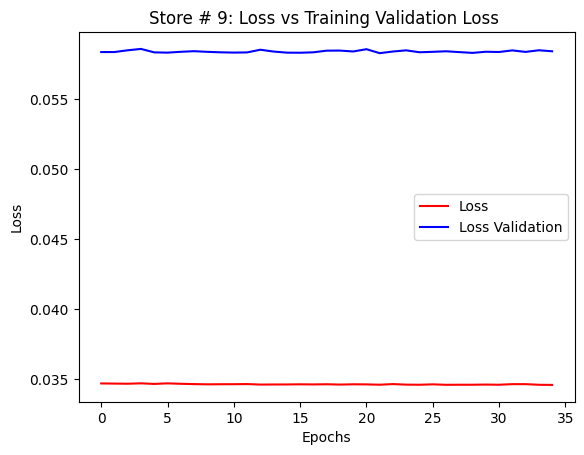

Epoch 1/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0649 - val_loss: 0.0295
Epoch 2/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0648 - val_loss: 0.0294
Epoch 3/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0647 - val_loss: 0.0297
Epoch 4/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0647 - val_loss: 0.0298
Epoch 5/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0647 - val_loss: 0.0300
Epoch 6/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0647 - val_loss: 0.0304
Epoch 7/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0647 - val_loss: 0.0309
Epoch 8/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0647 - val_loss: 0.0303
Epoch 9/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0647 - val_loss: 0.0305
Epoch 10/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0647 - val_loss: 0.0304
Epoch 11/35
24/24 [

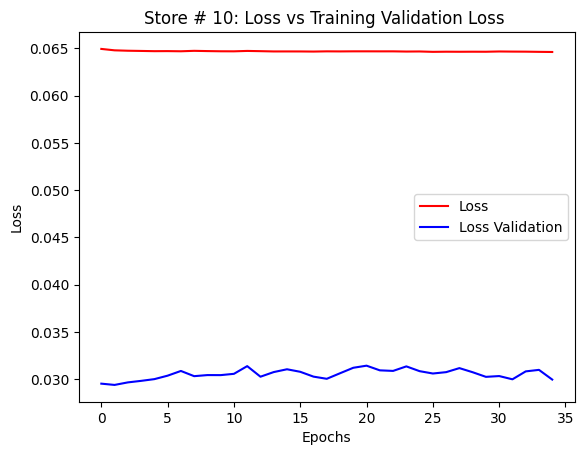

Epoch 1/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0573 - val_loss: 0.0703
Epoch 2/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0572 - val_loss: 0.0702
Epoch 3/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0572 - val_loss: 0.0703
Epoch 4/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0572 - val_loss: 0.0705
Epoch 5/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0571 - val_loss: 0.0702
Epoch 6/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0571 - val_loss: 0.0703
Epoch 7/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0571 - val_loss: 0.0702
Epoch 8/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0571 - val_loss: 0.0701
Epoch 9/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0571 - val_loss: 0.0702
Epoch 10/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0571 - val_loss: 0.0701
Epoch 11/35
24/24 [

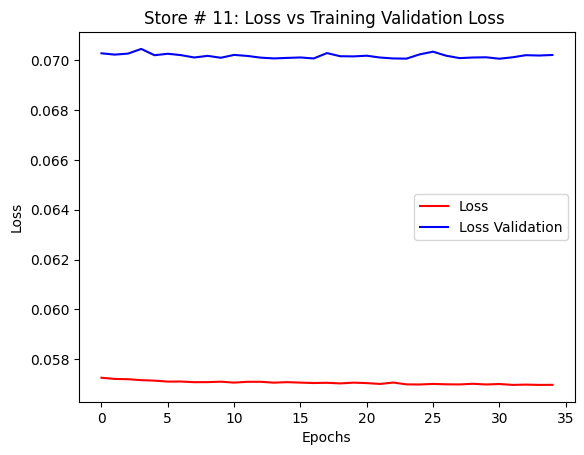

Epoch 1/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0243 - val_loss: 0.0734
Epoch 2/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0232 - val_loss: 0.0716
Epoch 3/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0219 - val_loss: 0.0666
Epoch 4/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0200 - val_loss: 0.0594
Epoch 5/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0177 - val_loss: 0.0509
Epoch 6/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0476
Epoch 7/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0153 - val_loss: 0.0463
Epoch 8/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0153 - val_loss: 0.0469
Epoch 9/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0152 - val_loss: 0.0467
Epoch 10/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0153 - val_loss: 0.0470
Epoch 11/35
24/24 [

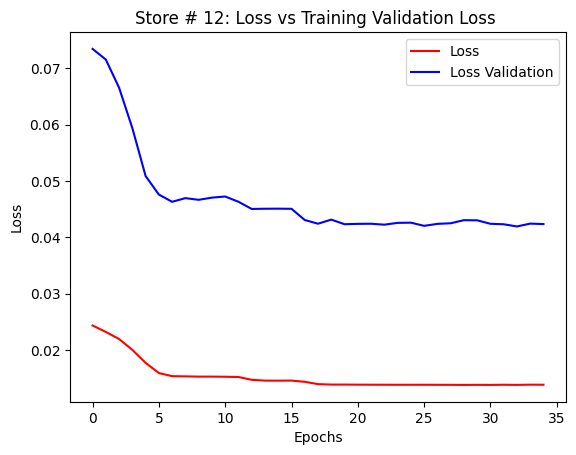

Epoch 1/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0214 - val_loss: 0.0382
Epoch 2/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0213 - val_loss: 0.0383
Epoch 3/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0213 - val_loss: 0.0381
Epoch 4/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0213 - val_loss: 0.0381
Epoch 5/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0213 - val_loss: 0.0381
Epoch 6/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0213 - val_loss: 0.0381
Epoch 7/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0213 - val_loss: 0.0381
Epoch 8/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0213 - val_loss: 0.0381
Epoch 9/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0213 - val_loss: 0.0384
Epoch 10/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0213 - val_loss: 0.0381
Epoch 11/35
24/24 [

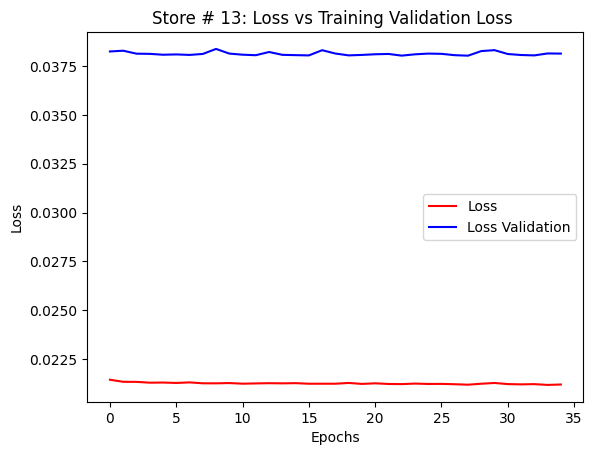

Epoch 1/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0299 - val_loss: 0.0394
Epoch 2/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0298 - val_loss: 0.0394
Epoch 3/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0298 - val_loss: 0.0394
Epoch 4/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0298 - val_loss: 0.0393
Epoch 5/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0298 - val_loss: 0.0394
Epoch 6/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0297 - val_loss: 0.0394
Epoch 7/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0298 - val_loss: 0.0394
Epoch 8/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0297 - val_loss: 0.0394
Epoch 9/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0297 - val_loss: 0.0393
Epoch 10/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0297 - val_loss: 0.0393
Epoch 11/35
24/24 [

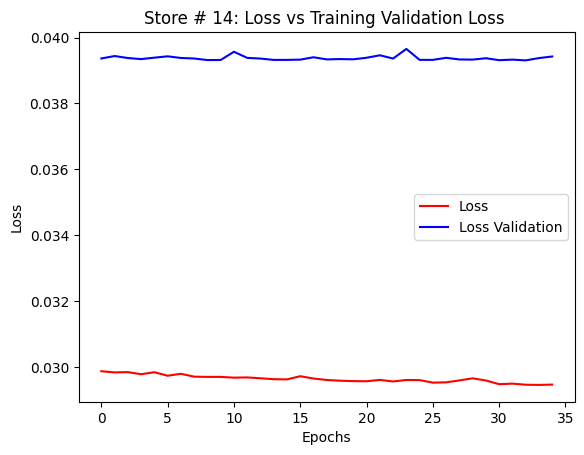

Epoch 1/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0201 - val_loss: 0.0422
Epoch 2/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0201 - val_loss: 0.0426
Epoch 3/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0202 - val_loss: 0.0428
Epoch 4/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0200 - val_loss: 0.0424
Epoch 5/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0200 - val_loss: 0.0425
Epoch 6/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0201 - val_loss: 0.0426
Epoch 7/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0200 - val_loss: 0.0422
Epoch 8/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0200 - val_loss: 0.0422
Epoch 9/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0200 - val_loss: 0.0424
Epoch 10/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0200 - val_loss: 0.0422
Epoch 11/35
24/24 [

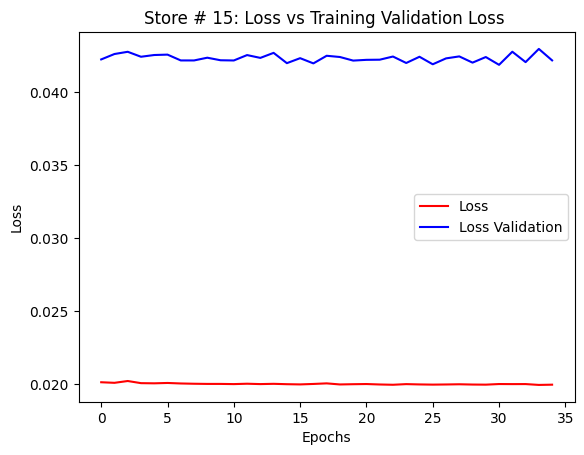

Epoch 1/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0316 - val_loss: 0.0269
Epoch 2/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0309 - val_loss: 0.0268
Epoch 3/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0307 - val_loss: 0.0269
Epoch 4/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0306 - val_loss: 0.0267
Epoch 5/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0306 - val_loss: 0.0269
Epoch 6/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0306 - val_loss: 0.0270
Epoch 7/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0305 - val_loss: 0.0268
Epoch 8/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0305 - val_loss: 0.0268
Epoch 9/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0305 - val_loss: 0.0268
Epoch 10/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0305 - val_loss: 0.0268
Epoch 11/35
24/24 [

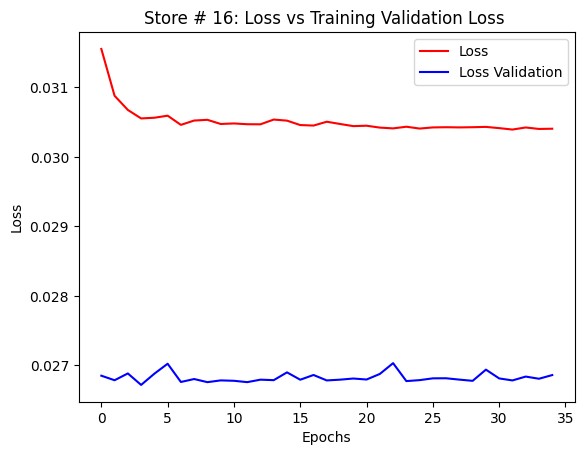

Epoch 1/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0198 - val_loss: 0.0341
Epoch 2/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0197 - val_loss: 0.0341
Epoch 3/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0197 - val_loss: 0.0341
Epoch 4/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0197 - val_loss: 0.0343
Epoch 5/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0197 - val_loss: 0.0341
Epoch 6/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0197 - val_loss: 0.0342
Epoch 7/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0197 - val_loss: 0.0341
Epoch 8/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0197 - val_loss: 0.0342
Epoch 9/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0196 - val_loss: 0.0342
Epoch 10/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0197 - val_loss: 0.0341
Epoch 11/35
24/24 [

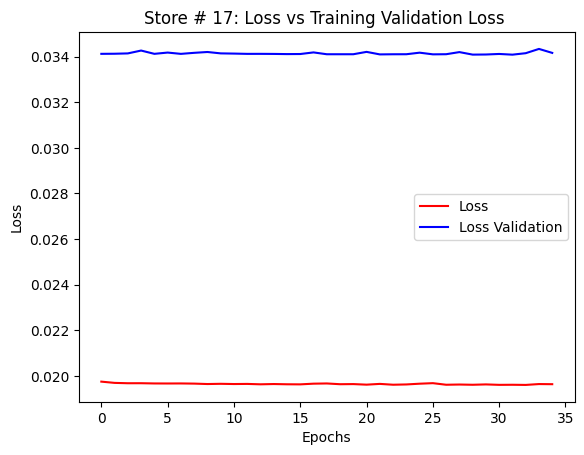

Epoch 1/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0254 - val_loss: 0.0231
Epoch 2/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0255 - val_loss: 0.0229
Epoch 3/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0254 - val_loss: 0.0228
Epoch 4/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0254 - val_loss: 0.0228
Epoch 5/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0254 - val_loss: 0.0228
Epoch 6/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0254 - val_loss: 0.0229
Epoch 7/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0254 - val_loss: 0.0229
Epoch 8/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0254 - val_loss: 0.0228
Epoch 9/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0254 - val_loss: 0.0229
Epoch 10/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0254 - val_loss: 0.0228
Epoch 11/35
24/24 [

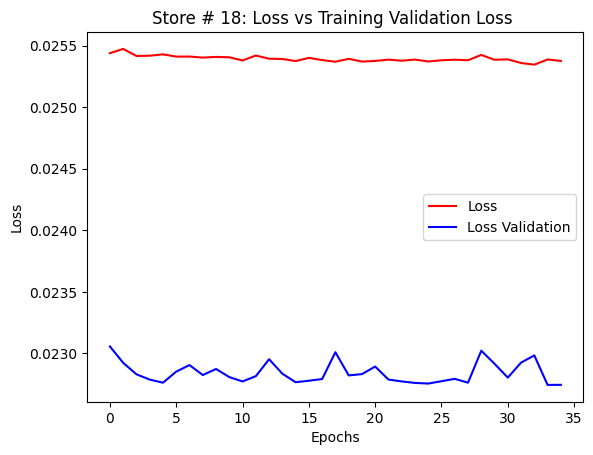

Epoch 1/35
24/24 [==============================] - 0s 8ms/step - loss: 0.0262 - val_loss: 0.0404
Epoch 2/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0261 - val_loss: 0.0405
Epoch 3/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0261 - val_loss: 0.0405
Epoch 4/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0261 - val_loss: 0.0404
Epoch 5/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0261 - val_loss: 0.0405
Epoch 6/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0261 - val_loss: 0.0404
Epoch 7/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0261 - val_loss: 0.0404
Epoch 8/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0260 - val_loss: 0.0404
Epoch 9/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0260 - val_loss: 0.0405
Epoch 10/35
24/24 [==============================] - 0s 7ms/step - loss: 0.0261 - val_loss: 0.0404
Epoch 11/35
24/24 [

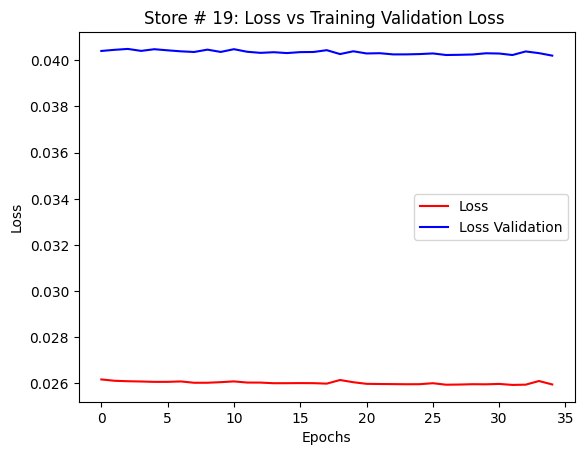

In [18]:
# Train on all stores up to num_stores
trainAllStores(model, num_stores, num_epochs, batch_size, start_bounds, middle_bounds, sequence_length)

12/12 [==============================] - 0s 1ms/step


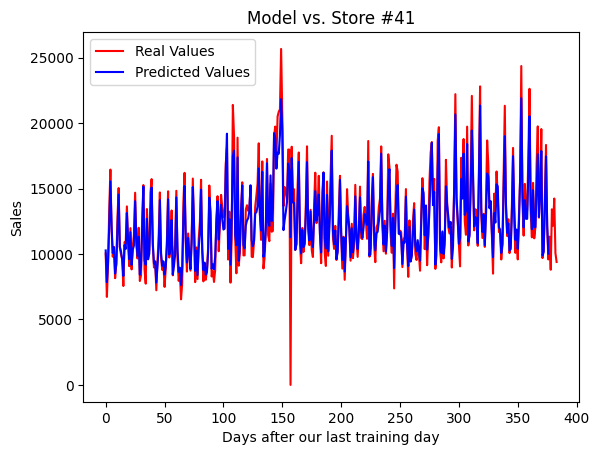

In [19]:
# Show model predictions for all stores up to num_stores
predictOneStore(model, store_num, start_bounds, middle_bounds)

We can see that, when trained on more stores, the model is able to better capture general trends in the data. In the initial test where we only trained one store #1, the model was not able to capture the smaller intricate ups and downs of the data. In addition to that, we also see that the local peak values are closer to the real local peak values and the same goes for the local minimums, generally. We can also see that the model loses sight of the very big outlier cases, as such for the data point around day 150. In our first prediction, it was able to get much closer to that specific peak value.

We also see that in this model, the loss vs. validation loss is very high. I beleive, this is due to the simplicity of the data being given to the model. Since my model is only trained on date and sales for that date, it could lead to the high difference between the two loss values shown.